# Fine-tune Gemma 3 1B-IT for Iris Species Classification

This tutorial covers the **fine-tuning process** of the recently launched **Gemma 3 1B** model for **Iris species classification**. The Iris dataset is a classic dataset in machine learning, containing measurements of flowers from three different Iris species: setosa, versicolor, and virginica.

We will:
- Convert numerical features (sepal_length, sepal_width, petal_length, petal_width) into categorical representations (low, medium, high)
- Use stratified sampling to ensure balanced representation across species
- Fine-tune Gemma 3 1B-IT to classify Iris species based on categorical feature descriptions

## Dataset Overview

The **Iris dataset** contains 150 samples of iris flowers with four features:
- **sepal_length**: Length of the sepal in centimeters
- **sepal_width**: Width of the sepal in centimeters  
- **petal_length**: Length of the petal in centimeters
- **petal_width**: Width of the petal in centimeters
- **species**: The species of iris (setosa, versicolor, virginica)

Each species has 50 samples, making it a balanced classification problem.

## Required Libraries

To implement this tutorial, we need to install several essential libraries:

In [1]:
!pip install -q -U transformers==4.50.0
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U peft
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U trl==0.18.0

# %pip install -q -U accelerate
# %pip install -q -U datasets
# %pip install -q -U peft==0.7.1  # Fixed version for compatibility
# %pip install -q -i https://pypi.org/simple/ bitsandbytes
# %pip install -q -U trl==0.7.10  # Fixed version for compatibility

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.7/374.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━

## Setting Environment Variables

The following code sets environment variables to configure the GPU usage and suppress unnecessary warnings:


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # Use the first GPU
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenization parallelism

## Suppressing Warnings

During training, several warnings may appear that do not impact the fine-tuning process but can be distracting. To suppress them:

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Importing Necessary Libraries

The following Python libraries are required for running the fine-tuning process:

In [4]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)

from transformers.models.gemma3 import Gemma3ForCausalLM

from datasets import Dataset
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer, SFTConfig
import bitsandbytes as bnb

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)

from sklearn.model_selection import train_test_split

2025-08-14 11:48:28.272743: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755172108.507055      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755172108.577432      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
print(f"transformers=={transformers.__version__}")

transformers==4.50.0


In [7]:
def define_device():
    """Determine and return the optimal PyTorch device based on availability."""
    
    print(f"PyTorch version: {torch.__version__}", end=" -- ")

    # Check if MPS (Metal Performance Shaders) is available for macOS
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("using MPS device on macOS")
        return torch.device("mps")

    # Check for CUDA availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"using {device}")
    return device

## Model Initialization

This code initializes the Gemma 3 1B model for causal language modeling, ensuring optimal settings based on the available hardware.


In [8]:
# Determine optimal computation dtype based on GPU capability
compute_dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16
print(f"Using compute dtype {compute_dtype}")

# Select the best available device (CPU, CUDA, or MPS)
device = define_device()
print(f"Operating on {device}")

# Path to the pre-trained model
GEMMA_PATH = "/kaggle/input/gemma-3/transformers/gemma-3-1b-it/1"

# Load the model with optimized settings
model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH,
    torch_dtype=compute_dtype,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    device_map=device
)

# Define maximum sequence length for the tokenizer
max_seq_length = 8192

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    GEMMA_PATH, 
    max_seq_length=max_seq_length,
    device_map=device
)

# Store the EOS token for later use
EOS_TOKEN = tokenizer.eos_token

Using compute dtype torch.float16
PyTorch version: 2.6.0+cu124 -- using cuda
Operating on cuda


In [9]:
is_on_gpu = all(param.device.type == 'cuda' for param in model.parameters())
print("Model is on GPU:", is_on_gpu)

Model is on GPU: True


### EDA to understand thresholds for "low", "medium" and "high" for each feature

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

data = pd.read_csv('/kaggle/input/iris-dataset-iitm-mlops/iris.csv')
data.head(5)
data['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

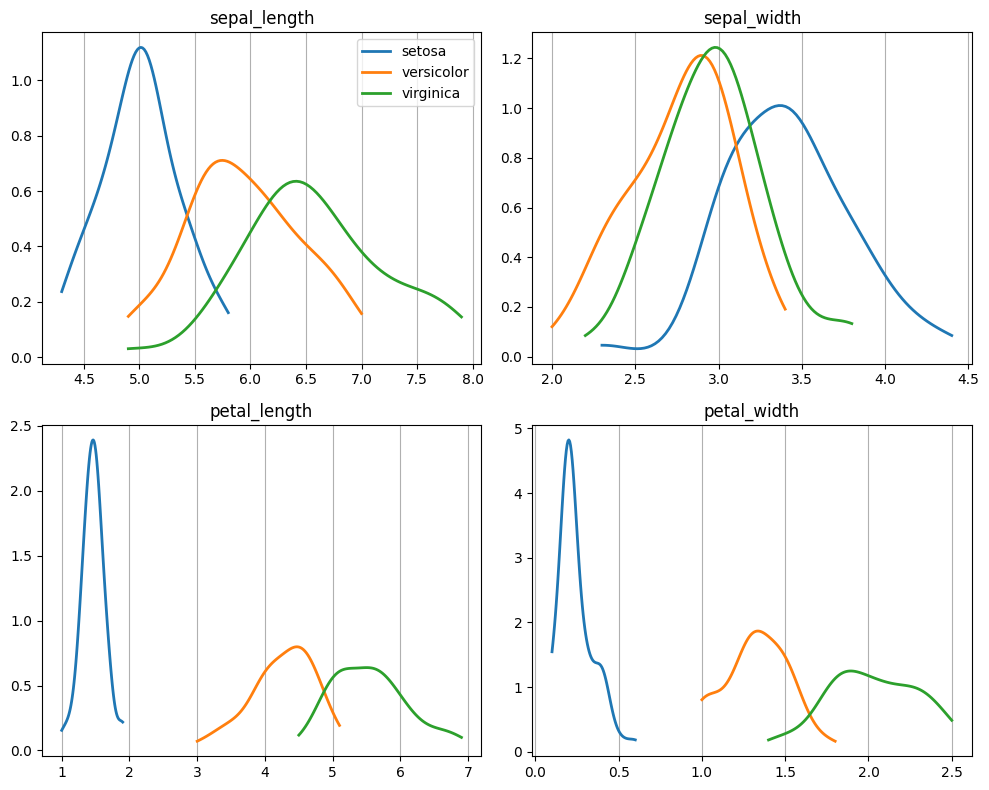

In [11]:
import matplotlib.pyplot as plt
from scipy import stats

features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
plt.figure(figsize=(10, 8))
for i, col in enumerate(features):
    plt.subplot(2, 2, i+1)
    for species in data['species'].unique():
        species_data = data[data['species'] == species]
        # Create a kernel density estimate
        kde = stats.gaussian_kde(species_data[col])
        x_range = np.linspace(species_data[col].min(), species_data[col].max(), 100)
        plt.plot(x_range, kde(x_range), label=species, linewidth=2)
    plt.title(col)
    plt.grid(True, axis='x')
    if i == 0:
        plt.legend()
plt.tight_layout()
plt.show()

### Looking at the graphs:

1. Sepal Length

Low: ~ 4.3 – 5.4 (covers setosa)

Medium: ~ 5.4 – 6.3 (covers versicolor)

High: ~ 6.3 – 7.9 (covers virginica)

2. Sepal Width

Low: ~ 2.0 – 2.7

Medium: ~ 2.7 – 3.3

High: ~ 3.3 – 4.4

3. Petal Length

Low: ~ 1.0 – 2.1 (setosa only)

Medium: ~ 3.0 – 5.0 (versicolor)

High: ~ 5.0 – 7.0 (virginica)

4. Petal Width

Low: ~ 0.1 – 0.6

Medium: ~ 1.0 – 1.6

High: ~ 1.6 – 2.5

I kept the boundaries at the gaps in the KDE curves to reduce overlap, so when I convert to text like "sepal length: low", I’ll avoid many ambiguous cases.

## Data Preprocessing Functions

The following functions handle the conversion of numerical features to categorical representations and prepare the dataset for training:

In [12]:
def categorize_features(df):
    """
    Convert numerical features to categorical representations (low, medium, high)
    based on domain-informed boundaries that align with species characteristics.
    """
    df_cat = df.copy()
    
    # Define feature-specific boundaries based on KDE analysis and species separation
    feature_boundaries = {
        'sepal_length': [5.4, 6.3],  # Low: 4.3-5.4, Medium: 5.4-6.3, High: 6.3-7.9
        'sepal_width': [2.7, 3.3],   # Low: 2.0-2.7, Medium: 2.7-3.3, High: 3.3-4.4
        'petal_length': [2.1, 5.0],  # Low: 1.0-2.1, Medium: 3.0-5.0, High: 5.0-7.0
        'petal_width': [0.6, 1.6]    # Low: 0.1-0.6, Medium: 1.0-1.6, High: 1.6-2.5
    }
    
    for feature, (low_high, medium_high) in feature_boundaries.items():
        # Categorize based on domain-informed boundaries
        df_cat[feature + '_cat'] = pd.cut(
            df[feature], 
            bins=[-np.inf, low_high, medium_high, np.inf], 
            labels=['low', 'medium', 'high']
        )
    
    return df_cat

def create_feature_description(row):
    """
    Create a natural language description of the iris features.
    """
    description = f"sepal length: {row['sepal_length_cat']}, sepal width: {row['sepal_width_cat']}, petal length: {row['petal_length_cat']}, petal width: {row['petal_width_cat']}"
    return description

## Dataset Preparation

The following code prepares the Iris dataset for fine-tuning by:
1. Loading the dataset
2. Converting numerical features to categorical
3. Creating stratified train-test splits
4. Generating natural language descriptions

In [13]:
# Load Iris dataset
pd.set_option('display.max_columns', None)
df = pd.read_csv("/kaggle/input/iris-dataset-iitm-mlops/iris.csv")

print(f"Dataset shape: {df.shape}")
print(f"Species distribution:\n{df['species'].value_counts()}")

# Convert numerical features to categorical
df_categorized = categorize_features(df)

# Create feature descriptions
df_categorized['feature_description'] = df_categorized.apply(create_feature_description, axis=1)

print("\nSample of categorized data:")
# df_categorized[['feature_description', 'species']].head()
print(df_categorized['feature_description'][0])


Dataset shape: (150, 5)
Species distribution:
species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

Sample of categorized data:
sepal length: low, sepal width: high, petal length: low, petal width: low


In [14]:
# Stratified train-test-eval split
# 90 samples for training, 30 samples for testing, 30 samples for evaluation
# (30 samples per species for training, 10 per species for testing, 10 per species for evaluation)

train_samples_per_species = 30
test_samples_per_species = 10
eval_samples_per_species = 10

X_train_list = []
X_test_list = []
X_eval_list = []

for species in df_categorized['species'].unique():
    species_data = df_categorized[df_categorized['species'] == species]
    
    # First split: train vs (test + eval)
    train_data, temp_data = train_test_split(
        species_data,
        train_size=train_samples_per_species,
        test_size=test_samples_per_species + eval_samples_per_species,
        random_state=42
    )
    
    # Second split: test vs eval from the temporary data
    test_data, eval_data = train_test_split(
        temp_data,
        train_size=test_samples_per_species,
        test_size=eval_samples_per_species,
        random_state=42
    )
    
    X_train_list.append(train_data)
    X_test_list.append(test_data)
    X_eval_list.append(eval_data)

# Combine and shuffle
X_train = pd.concat(X_train_list).sample(frac=1, random_state=42).reset_index(drop=True)
X_test = pd.concat(X_test_list).sample(frac=1, random_state=42).reset_index(drop=True)
X_eval = pd.concat(X_eval_list).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Evaluation set shape: {X_eval.shape}")
print(f"\nTraining set species distribution:\n{X_train['species'].value_counts()}")
print(f"\nTest set species distribution:\n{X_test['species'].value_counts()}")
print(f"\nEvaluation set species distribution:\n{X_eval['species'].value_counts()}")


Training set shape: (90, 10)
Test set shape: (30, 10)
Evaluation set shape: (30, 10)

Training set species distribution:
species
versicolor    30
setosa        30
virginica     30
Name: count, dtype: int64

Test set species distribution:
species
virginica     10
versicolor    10
setosa        10
Name: count, dtype: int64

Evaluation set species distribution:
species
virginica     10
versicolor    10
setosa        10
Name: count, dtype: int64


## Prompt Generation Functions

These functions create prompts for training and evaluation:

In [15]:
def generate_train_prompt(data_point):
    """Generate training prompts with expected answers for fine-tuning."""
    return f"""
    Classify the iris species based on the following flower measurements.
    Given the features, determine if it is setosa, versicolor, or virginica.
    
    Features: [{data_point["feature_description"]}]
    Species: {data_point["species"]}
    """.strip() + EOS_TOKEN

def generate_test_prompt(data_point):
    """Generate test prompts without expected answers for inference."""
    return f"""
    Classify the iris species based on the following flower measurements.
    Given the features, determine if it is setosa, versicolor, or virginica.
    
    Features: [{data_point["feature_description"]}]
    Species: 
    """.strip()

In [16]:
# Apply prompt generation to datasets
X_train_prompts = pd.DataFrame(X_train.apply(generate_train_prompt, axis=1), columns=["text"])
X_eval_prompts = pd.DataFrame(X_eval.apply(generate_train_prompt, axis=1), columns=["text"])

# Store ground truth labels for test data
y_true = X_test["species"]
X_test_prompts = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

# Convert to Hugging Face Dataset format
train_data = Dataset.from_pandas(X_train_prompts)
eval_data = Dataset.from_pandas(X_eval_prompts)

print("Sample training prompt:")
print(X_train_prompts.iloc[0]['text'])
print("\nSample test prompt:")
print(X_test_prompts.iloc[0]['text'])

Sample training prompt:
Classify the iris species based on the following flower measurements.
    Given the features, determine if it is setosa, versicolor, or virginica.
    
    Features: [sepal length: medium, sepal width: low, petal length: medium, petal width: medium]
    Species: versicolor<eos>

Sample test prompt:
Classify the iris species based on the following flower measurements.
    Given the features, determine if it is setosa, versicolor, or virginica.
    
    Features: [sepal length: high, sepal width: medium, petal length: high, petal width: high]
    Species:


In [54]:
print(X_train_prompts.iloc[4].values)

['Classify the iris species based on the following flower measurements.\n    Given the features, determine if it is setosa, versicolor, or virginica.\n    \n    Features: [sepal length: low, sepal width: medium, petal length: low, petal width: low]\n    Species: setosa<eos>']


## Training Configuration and Model Fine-tuning

The following cells set up the training configuration using LoRA (Low-Rank Adaptation) for parameter-efficient fine-tuning:


In [17]:
peft_config = LoraConfig(
    lora_alpha=32,
    lora_dropout=0.05,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules="all-linear",  # This works well with Gemma
)

training_arguments = SFTConfig(
    output_dir="logs_iris",
    num_train_epochs=4,  # Good for small dataset
    gradient_checkpointing=True,
    gradient_checkpointing_kwargs={"use_reentrant": False},
    per_device_train_batch_size=1,  # Start small due to memory constraints
    gradient_accumulation_steps=8,  # Maintain effective batch size
    optim="adamw_torch_fused",  # Use fused optimizer for efficiency
    save_steps=25,  # Adjusted for dataset size
    load_best_model_at_end=True,
    logging_steps=10,
    learning_rate=2e-4,  # Good learning rate for LoRA
    weight_decay=0.001,
    fp16=True if compute_dtype == torch.float16 else False,
    bf16=True if compute_dtype == torch.bfloat16 else False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    eval_strategy="steps",  # Fixed: changed from evaluation_strategy to eval_strategy
    eval_steps=25,
    eval_accumulation_steps=1,
    lr_scheduler_type="constant",
    report_to="tensorboard",  # Enable tensorboard for monitoring
    max_seq_length=max_seq_length,
    packing=False,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": True,
    },
    remove_unused_columns=False,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    processing_class=tokenizer, 
    args=training_arguments,
)


Converting train dataset to ChatML:   0%|          | 0/90 [00:00<?, ? examples/s]

Adding EOS to train dataset:   0%|          | 0/90 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/90 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/90 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/30 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/30 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [18]:
# Start the fine-tuning process
print("Starting model training...")
trainer.train()

# Save the fine-tuned model
lora_directory = "LoRA-Gemma3-iris-model"
trainer.model.save_pretrained(lora_directory)
trainer.processing_class.save_pretrained(lora_directory)
print(f"Model saved to {lora_directory}")

Starting model training...


Step,Training Loss,Validation Loss
25,0.125600,0.071718


Model saved to LoRA-Gemma3-iris-model


## Evaluation Functions

Functions to evaluate the model's performance on Iris classification:

In [85]:
def evaluate_iris(y_true, y_pred):
    """Evaluate the fine-tuned iris classification model's performance."""
    
    # Define species label mapping
    label_mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
    
    # Output validation
    valid_species = set(label_mapping.keys())
    invalid_predictions = [pred for pred in y_pred if pred not in valid_species]
    
    print(f"Validation Results:")
    print(f"  Total predictions: {len(y_pred)}")
    print(f"  Valid predictions: {len(y_pred) - len(invalid_predictions)}")
    print(f"  Invalid predictions: {len(invalid_predictions)}")
    print(f"  Validation rate: {(len(y_pred) - len(invalid_predictions)) / len(y_pred):.3f}")
    
    if invalid_predictions:
        print(f"  Invalid values found: {set(invalid_predictions)}")
    
    # Convert labels to numeric values
    y_true_numeric = np.array([label_mapping.get(label, -1) for label in y_true])
    y_pred_numeric = np.array([label_mapping.get(label, -1) for label in y_pred])
    
    # Calculate overall accuracy
    accuracy = accuracy_score(y_true_numeric, y_pred_numeric)
    print(f'\nOverall Accuracy: {accuracy:.3f}')
    
    # Compute accuracy for each species
    for species, label_num in label_mapping.items():
        species_mask = y_true_numeric == label_num
        if np.any(species_mask):
            species_accuracy = accuracy_score(y_true_numeric[species_mask], y_pred_numeric[species_mask])
            print(f'Accuracy for {species}: {species_accuracy:.3f}')
    
    # Generate classification report
    class_report = classification_report(
        y_true_numeric, 
        y_pred_numeric, 
        target_names=list(label_mapping.keys()),
        zero_division=0
    )
    print('\nClassification Report:\n', class_report)
    
    # Compute and display confusion matrix
    conf_matrix = confusion_matrix(y_true_numeric, y_pred_numeric, labels=[0, 1, 2])
    print('\nConfusion Matrix (rows=true, cols=predicted):\n', conf_matrix)
    print('\nSpecies order: setosa (0), versicolor (1), virginica (2)')

def predict_iris(X_test, model, tokenizer, device=device, max_new_tokens=10, temperature=0.0):
    """Predict the iris species for test samples."""
    
    y_pred = []
    validation_stats = {'valid': 0, 'invalid': 0, 'empty': 0}
    
    for i in tqdm(range(len(X_test)), desc="Predicting Iris Species"):
        prompt = X_test.iloc[i]["text"]
        
        # Tokenize and move input to device
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Generate output from the model
        with torch.no_grad():
            outputs = model.generate(
                **inputs, 
                max_new_tokens=max_new_tokens, 
                temperature=temperature,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
        
        # Decode the generated output
        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        # Extract only the generated part (after the original prompt)
        generated_text = full_response[len(prompt):].strip().lower()
        
        # Validate output is not empty
        if not generated_text:
            validation_stats['empty'] += 1
            y_pred.append("unknown")
            continue
        
        # Extract species prediction
        if "setosa" in generated_text:
            y_pred.append("setosa")
            validation_stats['valid'] += 1
        elif "versicolor" in generated_text:
            y_pred.append("versicolor")
            validation_stats['valid'] += 1
        elif "virginica" in generated_text:
            y_pred.append("virginica")
            validation_stats['valid'] += 1
        else:
            y_pred.append("unknown")
            validation_stats['invalid'] += 1
    
    # Print validation summary
    total = len(X_test)
    print(f"\nPrediction Validation Summary:")
    print(f"  Valid predictions: {validation_stats['valid']}/{total} ({validation_stats['valid']/total:.3f})")
    print(f"  Invalid predictions: {validation_stats['invalid']}/{total} ({validation_stats['invalid']/total:.3f})")
    print(f"  Empty outputs: {validation_stats['empty']}/{total} ({validation_stats['empty']/total:.3f})")
    
    return y_pred

## Single Example Prediction

Let's load the fine-tuned model and predict one example from the test set:

In [78]:
# Load the fine-tuned model for prediction
from peft import PeftModel
import pandas as pd

# Path to the fine-tuned LoRA model
lora_directory = "LoRA-Gemma3-iris-model"

# Load the base model
base_model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH,
    torch_dtype=compute_dtype,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    device_map=device
)

# Load the fine-tuned LoRA adapter
model_ft = PeftModel.from_pretrained(base_model, lora_directory)

# Load tokenizer
tokenizer_ft = AutoTokenizer.from_pretrained(lora_directory)
if tokenizer_ft.pad_token is None:
    tokenizer_ft.pad_token = tokenizer_ft.eos_token

print("Fine-tuned model loaded successfully!")

Fine-tuned model loaded successfully!


In [79]:
# Get example from X_test
index = 2

first_example = X_test.iloc[index]

# Convert to categorical features using the categorize_features function
test_df_categorized = categorize_features(X_test)
first_example_cat = test_df_categorized.iloc[0]
first_example

sepal_length                                                         6.4
sepal_width                                                          3.2
petal_length                                                         5.3
petal_width                                                          2.3
species                                                        virginica
sepal_length_cat                                                    high
sepal_width_cat                                                   medium
petal_length_cat                                                    high
petal_width_cat                                                     high
feature_description    sepal length: high, sepal width: medium, petal...
Name: 2, dtype: object

In [80]:
# Create feature description
feature_description = create_feature_description(first_example_cat)

# Create prompt for prediction
prompt = f"""
Classify the iris species based on the following flower measurements.
Given the features, determine if it is setosa, versicolor, or virginica.

Features: [{feature_description}]
Species: 
""".strip()

print(prompt)

Classify the iris species based on the following flower measurements.
Given the features, determine if it is setosa, versicolor, or virginica.

Features: [sepal length: high, sepal width: medium, petal length: high, petal width: high]
Species:


In [81]:
# Tokenize the prompt
inputs = tokenizer_ft(prompt, return_tensors="pt", padding=True, truncation=True, max_length=max_seq_length)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Generate prediction
with torch.no_grad():
    outputs = model_ft.generate(
        **inputs, 
        max_new_tokens=2,
        temperature=0.0,
        do_sample=False,
        pad_token_id=tokenizer_ft.eos_token_id
    )

# Decode the response
full_response = tokenizer_ft.decode(outputs[0], skip_special_tokens=True)
generated_text = full_response[len(prompt):].strip()

print(generated_text)

versicolor


In [82]:
# Extract species prediction
generated_lower = generated_text.lower()
if "setosa" in generated_lower:
    predicted_species = "setosa"
elif "versicolor" in generated_lower:
    predicted_species = "versicolor"
elif "virginica" in generated_lower:
    predicted_species = "virginica"
else:
    predicted_species = "unknown"

# Display results
print(f"Original features: {first_example['sepal_length']}, {first_example['sepal_width']}, {first_example['petal_length']}, {first_example['petal_width']}")
print(f"Categorical features: {feature_description}")
print(f"True species: {first_example['species']}")
print(f"Predicted species: {predicted_species}")
print(f"Generated response: '{generated_text}'")
print(f"Correct prediction: {predicted_species == first_example['species']}")

Original features: 6.4, 3.2, 5.3, 2.3
Categorical features: sepal length: high, sepal width: medium, petal length: high, petal width: high
True species: virginica
Predicted species: versicolor
Generated response: 'versicolor'
Correct prediction: False


### Test Set Evaluation

In [83]:
# Predict the entire test set using the existing predict_iris function
y_pred = predict_iris(X_test_prompts, model_ft, tokenizer_ft, device=device, max_new_tokens=10, temperature=0.0)

# Get true labels from X_test
y_true = X_test["species"].tolist()

# Evaluate using the existing evaluate_iris function
evaluate_iris(y_true, y_pred)

# Optional: Display some prediction examples
print("\nFirst 5 predictions:")
for i in range(30):
    print(f"Example {i+1}: True={y_true[i]}, Predicted={y_pred[i]}, Correct={y_true[i]==y_pred[i]}")

Predicting Iris Species: 100%|██████████| 30/30 [00:08<00:00,  3.60it/s]


Prediction Validation Summary:
  Valid predictions: 30/30 (1.000)
  Invalid predictions: 0/30 (0.000)
  Empty outputs: 0/30 (0.000)
Validation Results:
  Total predictions: 30
  Valid predictions: 30
  Invalid predictions: 0
  Validation rate: 1.000

Overall Accuracy: 0.633
Accuracy for setosa: 0.900
Accuracy for versicolor: 1.000
Accuracy for virginica: 0.000

Classification Report:
               precision    recall  f1-score   support

      setosa       0.82      0.90      0.86        10
  versicolor       0.53      1.00      0.69        10
   virginica       0.00      0.00      0.00        10

    accuracy                           0.63        30
   macro avg       0.45      0.63      0.52        30
weighted avg       0.45      0.63      0.52        30


Confusion Matrix (rows=true, cols=predicted):
 [[ 9  1  0]
 [ 0 10  0]
 [ 2  8  0]]

Species order: setosa (0), versicolor (1), virginica (2)

First 5 predictions:
Example 1: True=virginica, Predicted=versicolor, Correct=False
Ex

In [86]:
# Load separate base model instance for comparison
base_model = Gemma3ForCausalLM.from_pretrained(
    GEMMA_PATH,
    torch_dtype=compute_dtype,
    attn_implementation="eager",
    low_cpu_mem_usage=True,
    device_map=device
)

# Load base tokenizer
base_tokenizer = AutoTokenizer.from_pretrained(GEMMA_PATH)
if base_tokenizer.pad_token is None:
    base_tokenizer.pad_token = base_tokenizer.eos_token

print("Both base and fine-tuned models loaded successfully!")

Both base and fine-tuned models loaded successfully!


In [87]:
# Predict the entire test set using the existing predict_iris function
y_pred = predict_iris(X_test_prompts, base_model, base_tokenizer, device)

# Get true labels from X_test
y_true = X_test["species"].tolist()

# Evaluate using the existing evaluate_iris function
evaluate_iris(y_true, y_pred)

# Optional: Display some prediction examples
print("\nFirst 5 predictions:")
for i in range(30):
    print(f"Example {i+1}: True={y_true[i]}, Predicted={y_pred[i]}, Correct={y_true[i]==y_pred[i]}")

Predicting Iris Species: 100%|██████████| 30/30 [00:18<00:00,  1.67it/s]


Prediction Validation Summary:
  Valid predictions: 30/30 (1.000)
  Invalid predictions: 0/30 (0.000)
  Empty outputs: 0/30 (0.000)
Validation Results:
  Total predictions: 30
  Valid predictions: 30
  Invalid predictions: 0
  Validation rate: 1.000

Overall Accuracy: 0.333
Accuracy for setosa: 1.000
Accuracy for versicolor: 0.000
Accuracy for virginica: 0.000

Classification Report:
               precision    recall  f1-score   support

      setosa       0.33      1.00      0.50        10
  versicolor       0.00      0.00      0.00        10
   virginica       0.00      0.00      0.00        10

    accuracy                           0.33        30
   macro avg       0.11      0.33      0.17        30
weighted avg       0.11      0.33      0.17        30


Confusion Matrix (rows=true, cols=predicted):
 [[10  0  0]
 [10  0  0]
 [10  0  0]]

Species order: setosa (0), versicolor (1), virginica (2)

First 5 predictions:
Example 1: True=virginica, Predicted=setosa, Correct=False
Exampl